In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  5 20:42:38 2021

@author: prcohen
"""
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 26 16:31:20 2020

@author: prcohen
"""

import numpy as np
import pandas as pd


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

filepath = "/Users/prcohen/anaconda2/envs/aPRAM/Habitus/Data/Manobi Data/Original Steven 2017b/"
village = pd.read_excel(filepath+"translated_2017b/village_2017b_translated.xls")
farmer  = pd.read_excel(filepath+"translated_2017b/farmer_2017b_translated.xls")
plot    = pd.read_excel(filepath+"translated_2017b/plot_2017b_translated.xls")
season  = pd.read_excel(filepath+"translated_2017b/agSeason_2017b_translated.xls")


These files have already been translated to English (mostly, see below) but there are a lot of extraneous leading and trailing spaces in the column names and the cell values.  So I'm stripping all leading and trailing spaces. 

In [2]:
def strip_spaces (df):
    # strip leading and trailing spaces in all string-valued column names and values
    df.columns = [x.strip() for x in df.columns]
    return df.applymap(lambda x: x.strip() if type(x) == str else x)

village = strip_spaces(village)
farmer = strip_spaces(farmer)
plot = strip_spaces(plot)
season = strip_spaces(season)

Eventually, we want a dataset that has villages pointing to their constituent farm, farm pointing to plots and plots pointing to seasons.  We can't have this, yet, for two reasons:  First, season information is coded in such a way that we cannot tell which columns are for season 1 and which for season 2 (and where season 1 is identified there often isn't a corresponding season 2 column, and vice versa).  Second, there are lots of "childless" objects at all levels of the hierarchy, meaning villages without farms, farms without plots and plots without seasons. ("Orphans" or children without parents, are more rare.) The following puts numbers to these situations:

In [3]:
village_ht = {village.iloc[i]['X.ID']:{'kids': []} for i in range(len(village))}

def make_child_ht(child):
    return {child['X.ID']: {'parent_id': child['Parent.ID'], 'kids': [], 'has_parent':0} for child in
            [child.iloc[i] for i in range(len(child))]}

farmer_ht, plot_ht, season_ht  = make_child_ht(farmer), make_child_ht(plot), make_child_ht(season)

def check_parent_child (child_ht,parent_ht,child_name,parent_name):
    for k,v in child_ht.items():
        parent = parent_ht.get(v['parent_id']) # look for the parent id in parent
        if parent is not None:
            parent['kids'].append(k)            # add the child id to parent's kids
            v['has_parent'] = 1
    kids_with_parents = np.sum([v['has_parent'] for v in child_ht.values()])
    print (f"{kids_with_parents} of {len(child_ht)} {child_name}s exist in {parent_name} data")
    parents_without_kids = np.sum([v['kids']==[] for v in parent_ht.values()])
    print (f"{parents_without_kids} of {len(parent_ht)} {parent_name}s have no {child_name} data")


check_parent_child(farmer_ht,village_ht,'farmer','village')
check_parent_child(plot_ht,farmer_ht,'plot','farmer')
check_parent_child(season_ht,plot_ht,'season','plot')

# missing_villages = []
# for k,v in farmer_ht.items():
#     parent = village_ht.get(v['parent_id']) # look for the parent id in parent
#     if parent is None:
#         missing_villages.append((v['parent_id'],k))



def complete_chain (season_id):
    s = season_ht.get(season_id)
    if s is not None:
        p = plot_ht.get(s['parent_id'])
        if p is not None:
            f = farmer_ht.get(p['parent_id'])
            if f is not None:
                v = village_ht.get(f['parent_id'])
                if v is not None:
                    return True
    return False

print (f"We can trace a season record through plot, farmer and village for {sum([complete_chain(season_id) for season_id in season_ht.keys()])} records")

3838 of 3862 farmers exist in village data
3 of 71 villages have no farmer data
3385 of 3462 plots exist in farmer data
694 of 3862 farmers have no plot data
3107 of 3119 seasons exist in plot data
379 of 3462 plots have no season data
We can trace a season record through plot, farmer and village for 3043 records


# Cleaning the farmer dataset #

Next I'll clean the village data and farmer data. There isn't much to do with the village dataset, though see below for the section on calculating village and cooperative statistics.  Cleaning means dropping some columns, renaming others (usually to make them consistent across data sets), eliminating outliers, recoding some values as integers, and binning distributions. In general, I am renaming all column names that include spaces with names that don't (e.g., 'Access to health care' -> 'access_healthcare') and eliminating all upper case and camel case, as it was too hard for me to remember the column names. 

In [4]:
###############################################################################
########  Clean the village data

village.drop(columns=[
    'fertilizerType_season2',
    'Parent.ID'
    ],
    inplace = True, errors = 'ignore')

village.rename(columns = {
    'X.ID' : 'village_id',
    'villageName\n        Name': 'village_name',
    'Rain gauge in the village': 'has_rain_gauge',
    'villageCenter' : 'lat_long'
    },
    inplace = True)


###############################################################################
########  Clean the farmer data

farmer.drop(columns=[
    'Status', 'Other', 'AnnEe.d.adhEsion.','Search for buyer',
    'paymentDelay', 'Search for buyer.1','Search for buyer.2',
    'Search for buyer.3',
    'othercrop_season1\n  storageLocation2\n If other, precise',
    'If yes, amount to cover\n  If yes, ability to pay',
    'Si.oui..montant..garantir.','Unnamed'
    ],
    inplace = True, errors = 'ignore')

farmer.rename(columns = {
    'X.ID' : 'id',
    'Parent.ID':'village_id',
    'Object.state' : 'validation_status',
    'Accuracy' : 'accuracy',
    'farmerCooperative' : 'coop_name',
    'Access to electricity':'access_electricity',
    'Access to drinking water' : 'access_drinking_water',
    'Access to health care' : 'access_healthcare',
    'Housing material' : 'housing_material',
    'numberWives' : 'num_wives',
    'wifeTrades' : 'wife_trades',
    'wifeFoodCrops' : 'wife_food_crops',
    'wifeCrafts' : 'wife_crafts',
    'childrenWorking' : 'children_working',
    'Transportation means' : 'transportation',
    'wantsCredit': 'wants_credit',
    'creditCooperative' : 'credit_from_coop',
    'creditThirdParty' : 'credit_from_third_party',
    'creditBank' : 'credit_from_bank',
    'loanAmount' : 'loan_amount',
    'loanRate' : 'loan_rate',
    'existingBridgeLoan' : 'has_bridge_loan',
    'bridgeLoanAmount' : 'bridge_loan_amount',
    'wantsBridgeLoan' : 'wants_bridge_loan',
    'wantsBridgeLoanAmount' : 'wants_bridge_loan_amount',
    'pledgedOutput' : 'pledged_output',
    'inputUse' : 'input_use',
    'inputCosts' : 'input_cost',
    'lastPrice' : 'last_price',
    'totalHa' : 'total_ha',
    'mainCrop' : 'main_crop',
    'secondaryCrop' : 'secondary_crop',
    'Nbr children < 6 years' : 'num_young_children',
    'Nbr children 6-18 years' : 'num_older_children',
    'numChildren' : 'num_children',
    'numChildrenInSchool' : 'num_children_in_school',
    'educationLevel' : 'education_level',
    'numPlots_farmer' : 'num_plots',
    'Nbr years in activity' : 'years_farming',
    'Inputs usefulness' : 'inputs_useful',
    'IntErIt.usage.intrants' : 'interest_use_inputs',
    'IntErIt.assurance.agricole' : 'interest_insurance',
    'Agricultural services' : 'use_ag_services',
    'Farm advisory quality' : 'ag_services_quality',
    'Farm advisory frequency' : 'ag_services_frequency',
    'Interest for farm advisory' : 'interest_ag_services',
    'buyerType' : 'buyer_type'
                       },
    inplace = True)

The following code gets rid of outliers.  Values that are not in the specified range are replaced by NaNs.

In [5]:
##############################################################################
### correct the ranges of farmer. For example, no-one is 200 years old.

def correct_range (df, col, minval, maxval, report=False):
    n = df[col].count()
    if report: print(f"Before cleaning, {col} count = {df[col].count()}, min = {df[col].min()}, max = {df[col].max()}")
    df[col].where((df[col]>=minval) & (df[col]<=maxval),inplace=True)
    if report: print(f"{df[col].describe()}")
    if report: print(f"Newly Nan records: {n - df[col].count()}\n")

print(farmer.age.max())
correct_range(farmer,'age',18,100)
print(farmer.age.max())
correct_range(farmer,'years_farming',0,100)
correct_range(farmer,'num_children',0,20)
correct_range(farmer,'income',0,2000000)
correct_range(farmer,'has_bridge_loan', 0, 1000000)
correct_range(farmer,'wants_bridge_loan_amount',0,1500000)
correct_range(farmer,'input_cost',0,500000)
correct_range(farmer,'last_price', 0, 400)
correct_range(farmer,'num_plots', 0, 10)

478
98.0


Total Ha is very unreliable. Roughly 350 farms have total_ha > 3, which is pretty big for
smallhold farms.  The mean size of these farms is 34.27 Ha, and in several villages
all the farms have a single value for total_ha.  For example, village 708 has dozens of farms
each of which has 70Ha as total_ha. 

I'm setting the total_ha value to nan for every farm
in each of these villages because these values are constant and large for these villages.

Steven suggests using plot boundaries (from the plot data file) instead of total_ha.  However, we don't have plot data for many of the farms that have extremely high total_ha.  


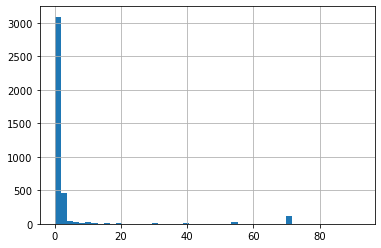

In [6]:
farmer.total_ha.hist(bins=50)

for i in range(len(farmer)):
    farm = farmer.iloc[i]
    if farm.village_id in [448, 490, 495, 500, 503, 567, 674, 675, 681, 684, 682,
                           708, 715, 747, 751, 754]:
        farmer.at[i,'total_ha'] = np.nan

# and for the few very large total_ha values that are not in these villages, I will
# correct the range

correct_range(farmer,'total_ha', 0, 10)

It appears that the farmer data codes "no loan" as loanAmount = 0 and loanRate = 0 :

In [7]:
print(pd.crosstab(farmer.loan_amount>0,farmer.loan_rate>0))

loan_rate    False  True 
loan_amount              
False         1590    148
True            47   2077


So I will create a new column called has_loan with values 0 and 1 where I code
the off-diagonal values as NaN. Note that I'm coding loan amounts in excess of 10^6 as outliers (NaNs) and similarly for loan rates in excess of 20%. Are these realistic ranges?

In [8]:
def loan_status (row):
    if row.loan_amount == 0 and row.loan_rate == 0:
        return 0
    elif row.loan_amount > 0 and row.loan_rate > 0:
        return 1
    else:
        return np.nan

farmer['has_loan'] = farmer.apply(loan_status,axis=1)

# Now we can correct the ranges on loan_amount and loan_rate
correct_range(farmer,'loan_amount', 1, 1000000)
correct_range(farmer,'loan_rate',.1,20)

Sometimes, a farm reports having fewer children than children in school.  This complicates the calculation of the fraction of children in school.  The column valid_children contains True when there are at least as many children as there are children in school and False otherwise.  The fraction of children in school is calculated for True cases and is NaN for False cases:

<AxesSubplot:>

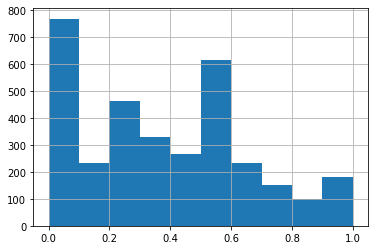

In [9]:
farmer['valid_children'] = farmer.num_children >= farmer.num_children_in_school
farmer['fraction_in_school'] = [
    s/n if (v and n > 0) else np.nan for s,n,v in zip(farmer.num_children_in_school, farmer.num_children, farmer.valid_children) ]

farmer.fraction_in_school.hist()

Now I'll recode a lot of categorical values as integers.  I followed the general principle that smaller integers should correspond to lower, less desirable, less normative, or negative values; for example, "no" and "yes" become 0 and 1; 'not interested', 'a little interested', 'moderately interested', 'interested' and 'very interested' are coded as 0,1,2,3,4.  The point of this recoding is to give a quick look at a group of farmers by taking means of these variables; for example, if agricultural service quality is recoded as 0,1,2,3 then larger means tell us that the group is happier with the services.  

Someone with local knowledge should check whether I have interpreted the "goodness" of the categories correctly; for example, I think "Paille/Plastique" <  "Bois" < "Terre sEchEe/Banco" < "Briques" = "BEton" for housing materials, but I don't really know!

In [10]:
farmer.access_electricity.replace(
    to_replace={"not at all":0, "Compteur": 1, "Solaire":1},inplace=True)

farmer.access_drinking_water.replace(
    to_replace={"RiviEre/Marigot":0, "Puit": 1, "Pompe hydraulique":1, "Robinet":2},inplace=True)

farmer.access_healthcare.replace(
    to_replace={"not at all":0, "bad":0, "medium": 1, "good":2, "very good":2},inplace=True)

farmer.housing_material.replace(
    to_replace={"Paille/Plastique": 0, "Bois":0, "Terre sEchEe/Banco": 1, "Briques":2, "BEton":2},inplace=True)

farmer.gender.replace(
    to_replace={"Mr": 0, "Mme":1, "Mlle":2},inplace=True)

farmer.wife_trades.replace(    to_replace={"No":0,"Yes":1}, inplace=True)
farmer.wife_food_crops.replace( to_replace={"No":0,"Yes":1}, inplace=True)
farmer.wife_crafts.replace(    to_replace={"No":0,"Yes":1}, inplace=True)

farmer.children_working.replace(
    to_replace = {'never':0, 'sometimes': 1, 'during vacation only': 2,
                  'Plusieurs fois par semaine': 3, 'tous les jours': 4},
    inplace=True)

farmer.wants_credit.replace(
    to_replace= {'not interested' : 0, 'a little interested' : 1,
                 'moderately interested' : 2, 'interested' : 3, 'very interested' : 4},
    inplace=True)

farmer.credit_from_coop.replace(
    to_replace={'never' : 0, 'sometimes' : 1, 'always': 2},
    inplace=True)

farmer.credit_from_third_party.replace(
    to_replace={'never' : 0, 'sometimes' : 1, 'always': 2},
    inplace=True)

farmer.credit_from_bank.replace(
    to_replace={'never' : 0, 'sometimes' : 1, 'always': 2},
    inplace=True)

farmer.pledged_output.replace(
    to_replace={'no' : 0, 'partly' : 1, 'yes': 2},
    inplace=True)

farmer.wants_bridge_loan.replace(to_replace={'no' : 0, 'yes' : 1}, inplace=True)

farmer.interest_insurance.replace(
    to_replace={'no' : 0, 'maybe' : 1, 'Peut-Itre': 1, 'yes' : 2},
    inplace=True)

farmer.input_use.replace(
    to_replace={'not at all' : 0, 'very little' : 1, 'sometimes' : 2,
                'half recommended dose' : 3, 'recommended dose' : 4},
    inplace=True)

farmer.inputs_useful.replace(
    to_replace={'no' : 0, 'maybe' : 1, 'Peut-Itre': 1, 'yes' : 2},
    inplace=True)

farmer.interest_use_inputs.replace(
    to_replace={'no' : 0, 'maybe' : 1, 'Peut-Itre': 1, 'yes' : 2},
    inplace=True)

farmer.use_ag_services.replace(
    to_replace={'Aucun' : 0, 'ANCAR' : 2, 'Autres' : 1},
    inplace=True)

farmer.ag_services_quality.replace(
    to_replace={'not at all' : 0, 'fair': 0, 'medium' : 1, 'good':2, 'very good':3},
    inplace=True)

farmer.ag_services_frequency.replace(
    to_replace={
        'Aucune visite' : 0,
        'any visite' : 0,
        '1  2 visites par an': 1,
        '1  2 visites par semestres' : 2,
        '1  2 visites par trimestres' : 2,
        '1 visite par mois' : 3,
        '2 visites par mois' : 4},
    inplace=True)

farmer.interest_ag_services.replace(
    to_replace={'no' : 0, 'maybe' : 1, 'Peut-Itre': 1, 'yes' : 2},
    inplace=True)

farmer.buyer_type.replace(
    to_replace={'market' : 'market', 'lender': 'lender',
                'CoopErative':'coop','itinerant merchant' : 'merchant'},
    inplace=True)

farmer.main_crop.replace(
    to_replace={'irrigated rice': 'IRice','rainfed rice': 'RRice',
                'market gardening': 'garden'},
    inplace=True)

farmer.secondary_crop.replace(
    to_replace={'irrigated rice': 'IRice',
                'rainfed rice': 'RRice',
                'market gardening': 'garden',
                'Elevage': 'elevage',
                'maize': 'maize',
                'NiEbE': 'niebe',
                'Sorgho':'sorghum',
                'millet' : 'millet',
                'SEsame':'sesame',
                'peanut': 'peanut'},
    inplace=True)

I will bin some continuous variables.  Some are binned by quartiles, while I binned others by looking at the distributions to find reasonable cut-points. Again, these should be reviewed by someone with local knowledge.

In [11]:
###############################################################################
### Binning some continuous variables

def map_to_bins (attribute,bins):
    farmer[attribute+'_binned'] = pd.cut(
        farmer[attribute],
        bins,
        labels = list(range(len(bins)-1)),
        right=False).astype(float)
    # astype(float) otherwise the bin nums are treated as categories and we can't take their mean etc.

def map_to_quartile_bins (attribute):
    fa = farmer[attribute]
    bins = [fa.min(),fa.quantile(.25),fa.quantile(.5),fa.quantile(.75),fa.max()+.1]
    map_to_bins (attribute,bins)

map_to_quartile_bins('fraction_in_school')
map_to_quartile_bins('income') # see comments about income below

fis = farmer.fraction_in_school
bins = [fis.min(),fis.quantile(.25),fis.quantile(.5),fis.quantile(.75),fis.max()+.1]
map_to_bins('fraction_in_school',bins)


map_to_bins ('num_plots', [0,2,4,farmer.num_plots.max()+1])
map_to_bins ('years_farming',[0,10,18,28,farmer['years_farming'].max()+1])
map_to_bins ('age', [0,30,40,50,60,farmer.age.max()+1])
map_to_bins ('num_children', [0,4,8,farmer.num_children.max()+1])
map_to_bins('num_older_children',[0,1,5,999])
map_to_bins('num_young_children',[0,1,5,999])
map_to_bins('num_wives',[0,1,2,farmer.num_wives.max()+1]) # 0 for 0 wives, 1 for 1 wife, 2 for >1 wife

The next cases of binning are particularly important because the variables seem to have large causal roles.  The original data has five education levels but I recoded it as just two.  I tried three groups: ('AlphabEtisE','Non AlphabEtisE'),('Primaire') and ('SupErieur','Secondaire') but lost statistical power, so I kept the first group (which is very low education) and merged Primaire into the second. 

Women's roles are logical combinations of two activities, marketing and food cropping.  (A third activity, crafting, has near zero incidence, so I dropped it.) wife_roles = 0 if the wife neither crops not trades, 1 if she does one or the other but not both, and 2 if she does both. However, we need some clarity on all data pertaining to women.  For example, you'll see a cross-tabulation of wife_trades with num_wives that shows 103 cases where num_wives = 0 yet wife_trades = 1. Something's wrong -- a wife can't trade if there isn't a wife -- but I don't know what.  A cross-tabulation with wife_roles gives more meaningful results but only because wife_roles is defined only when there's a wife and is NaN otherwise.  

More generally, you'll see that nearly 800 of the respondents are female, but I don't know their roles on the farm.  The cross-tabulation between wife_trades and the gender of the respondent might provide a clue:  when the respondent is female (gender = 1 or 2), 14% of the time the wife trades, whereas when the respondent is male, 39% of the time the wife trades.  Could it be that some of the female respondents are thinking "who is this wife they are asking about? I don't have a wife, so she doesn't trade."  But even if this is the right interpretation, we still doin't know whether female respondents are proprietors, or wives who run the farm (perhaps while the husband works elsewhere) or are wives who just happened to be home and are speaking on behalf of the husband farmer, etc.

num_wives      0     1    2   3   4   6   11  13
wife_trades                                     
0            1102  1366  369  56  17   1   1   1
1             103   572  226  45   3   0   0   0

num_wives     1    2   3   4   6   11  13
wife_roles                               
0.0         1183  298  46  15   1   1   1
1.0          546  231  37   5   0   0   0
2.0          209   66  18   0   0   0   0

gender        0.0  1.0  2.0
wife_trades                
0            2186  691    7
1             852   94    1


<AxesSubplot:>

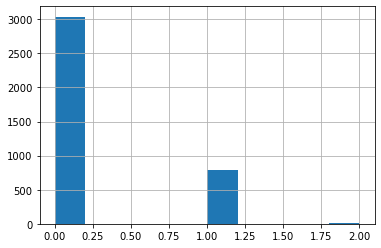

In [12]:
def education (row):
    """returns 0 if illiterate or preschool, 1 is education level is elementary school,
    middle school or high-school and above"""
    if row.education_level == 'AlphabEtisE' or row.education_level == 'Non AlphabEtisE':
        return 0
    elif  row.education_level == 'Primaire' or row.education_level == 'SupErieur' or row.education_level == 'Secondaire':
        return 1
    else:
        return np.nan

farmer['education_level_binned'] = farmer.apply(education,axis=1)

def women_role (row):
    if row.num_wives > 0:
        if row.wife_trades == 0 and row.wife_food_crops == 0:
            return 0
        if (row.wife_trades == 1 or row.wife_food_crops == 1 ) and (not (row.wife_trades == 1 and row.wife_food_crops == 1 )):
            return 1
        if (row.wife_trades == 1 and row.wife_food_crops == 1 ):
            return 2
    else:
        return np.nan

farmer['wife_roles'] = farmer.apply(women_role,axis=1)

print(pd.crosstab(farmer.wife_trades,farmer.num_wives))
print()
print(pd.crosstab(farmer.wife_roles,farmer.num_wives))
print()
print(pd.crosstab(farmer.wife_trades,farmer.gender))
farmer.gender.hist()


The next two recodings also have big causal roles and also raise questions of interpretation. We don't know whether a farmer is creditworthy, so I came up with a heuristic definition:  If the farmer doesn't have a loan at present and says he or she "never" gets credit from a bank, then creditworthy = 0.  If the farmer has a loan then creditworthy=1. All other cases are NaN. 

Income is a bit of a headache because of the large number of farmers for which income == 0. The problem is that income is one of the most important variables in our model of value chains so we'd *really* like to know whether zero  really means zero or something else, such as "unknown" or "too early in the season to know" etc. The zeros also play havoc with regression analysis, though for contingency table analysis and bayesian networks it seems ok to bin income into quartiles. 

In [13]:
def creditworthy (row):
    if row.has_loan == 0 and row.credit_from_bank == 0:
        return 0
    elif row.has_loan == 1:
        return 1
    else:
        return np.nan

farmer['creditworthy'] = farmer.apply(creditworthy,axis=1)

print(f"{np.sum(farmer.income == 0)} of {len(farmer)} farmers have zero income. Mean/median income is {int(farmer.income.mean())},{int(farmer.income.median())}")

def positive_income (row):
    if row.income > 0:
        return row.income
    else:
        return np.nan

farmer['nonzero_income'] = farmer.apply(positive_income,axis=1)

print(f"Mean/median nonzero income is {int(farmer.nonzero_income.mean())} / {int(farmer.nonzero_income.median())}")


## add a list of plot ids to each farmer

605 of 3862 farmers have zero income. Mean/median income is 243007,170000
Mean/median nonzero income is 288566 / 200000


I'll hash coop names to integers for use later, when I make a coop dataset.  I'll also add plot IDs to farmer records, even though I'm not yet using plot information because most of it comes "upward" from season information, which is flaky.  

Finally, I'll write out the cleaned data.

In [14]:
def hash_to_integers (col):
    """ Builds a hash table that maps the values in col to integers starting at 0.
    There will be as many unique integers as there are unique values. Returns the
    hash table."""
    ht, i = {}, -1
    for val in col:
        if ht.get(val) is None:
            i+=1
            ht[val] = i
    return ht

farmer['coop_id'] = farmer.coop_name
farmer.coop_id.replace(hash_to_integers(farmer.coop_name),inplace=True)

farmer['plot_list'] = [[] for i in range(len(farmer))]
parent_to_plot_ht = {}
for k,v in plot_ht.items():
    p = v['parent_id']
    if parent_to_plot_ht.get(p):
        parent_to_plot_ht[p].append(k)
    else:
        parent_to_plot_ht[p] = [k]

farmer['plot_list'] = farmer.apply(lambda x: parent_to_plot_ht.get(x.id) or np.nan, axis=1)

farmer.to_csv(filepath+"demographicfarmer_2017b_cleaned.csv",index=False)

In [15]:
f = pd.read_csv(filepath+"demographicfarmer_2017b_cleaned.csv")

In [16]:
f.head(10)

,id,village_id,validation_status,accuracy,farmerDate,coop_name,gender,age,years_farming,education_level,num_wives,wife_trades,wife_food_crops,wife_crafts,num_children,num_young_children,num_older_children,num_children_in_school,children_working,income,transportation,housing_material,access_electricity,access_drinking_water,access_healthcare,wants_credit,credit_from_coop,credit_from_third_party,credit_from_bank,loan_amount,loan_rate,has_bridge_loan,bridge_loan_amount,pledged_output,wants_bridge_loan,wants_bridge_loan_amount,input_use,input_cost,inputs_useful,interest_use_inputs,interest_insurance,use_ag_services,ag_services_quality,ag_services_frequency,interest_ag_services,buyer_type,last_price,num_plots,total_ha,main_crop,secondary_crop,has_loan,valid_children,fraction_in_school,fraction_in_school_binned,income_binned,num_plots_binned,years_farming_binned,age_binned,num_children_binned,num_older_children_binned,num_young_children_binned,num_wives_binned,education_level_binned,wife_roles,creditworthy,nonzero_income,coop_id,plot_list
0,3832,457,Validated,2,2016-12-27 13:08:00,it1,0.0,44.0,15.0,AlphabEtisE,1,1,0,0,5.0,1,4,5,NaN,1000680.0,Moto/Mobylette,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,395000.0,14.0,0.0,0,0.0,0.0,0.0,4.0,100000.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,market,125.0,1.0,0.40,IRice,garden,1.0,True,1.000000,3.0,3.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1000680.0,0,[7801]
1,3833,457,Validated,5,2016-12-27 13:08:00,it1,0.0,66.0,15.0,AlphabEtisE,2,0,1,0,6.0,0,6,2,0.0,798000.0,A pied,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,100000.0,7.0,100000.0,115000,0.0,1.0,20000.0,4.0,70000.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,market,125.0,1.0,0.10,IRice,garden,1.0,True,0.333333,2.0,3.0,0.0,1.0,4.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,798000.0,0,[7244]
2,3846,457,Validated,3,2016-12-27 13:08:00,it1,0.0,47.0,35.0,AlphabEtisE,1,0,1,0,10.0,5,3,4,0.0,375000.0,A pied,0.0,0.0,2.0,1.0,3.0,1.0,0.0,1.0,90000.0,7.0,60000.0,70000,0.0,1.0,500000.0,4.0,51000.0,1.0,1.0,2.0,1.0,1.0,3.0,2.0,market,125.0,8.0,2.75,NaN,garden,1.0,True,0.400000,2.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,375000.0,0,[5784]
3,3847,457,Validated,3,2016-12-27 13:08:00,it1,0.0,82.0,37.0,AlphabEtisE,1,0,1,0,13.0,0,1,13,1.0,100000.0,A pied,2.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,10000.0,7.0,100000.0,110000,0.0,1.0,10000.0,4.0,24500.0,1.0,1.0,2.0,1.0,1.0,3.0,2.0,market,125.0,5.0,2.30,IRice,garden,1.0,True,1.000000,3.0,1.0,2.0,3.0,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,100000.0,0,[5209]
4,3848,457,Validated,2,2016-12-27 13:08:00,it1,0.0,65.0,35.0,AlphabEtisE,2,1,0,0,9.0,2,2,4,0.0,0.0,A pied,2.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,500000.0,18.0,500000.0,544000,0.0,1.0,250000.0,4.0,85000.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,market,125.0,8.0,3.08,IRice,garden,1.0,True,0.444444,2.0,0.0,2.0,3.0,4.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,NaN,0,[5211]
5,3851,458,Validated,4,2016-12-27 13:08:00,it1,1.0,51.0,10.0,AlphabEtisE,0,0,0,0,1.0,0,0,1,0.0,200000.0,Voiture,2.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,500000.0,7.0,0.0,0,0.0,0.0,0.0,3.0,300000.0,0.0,2.0,0.0,1.0,3.0,4.0,2.0,market,350.0,6.0,1.00,IRice,IRice,1.0,True,1.000000,3.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,200000.0,0,NaN
6,3946,458,Validated,2,2016-12-27 13:08:00,it1,0.0,71.0,0.0,Non AlphabEtisE,1,0,0,0,9.0,0,0,2,4.0,50000.0,Moto/Mobylette,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,4.0,100000.0,1.0,2.0,0.0,2.0,1.0,NaN,0.0,market,300.0,1.0,0.10,IRice,RRice,0.0,True,0.222222,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,50000.0,0,[7805]
7,3947,458,Validated,2,2016-12-27 13:08:00,it1,0.0,62.0,20.0,Non AlphabEtisE,1,1,1,0,9.0,1,2,0,4.0,0.0,Voiture,2.0,1.0,2.0,1.0,3.0,1.0,2.0,0.0,NaN,NaN,0.0,0,0.0,NaN,0.0,4.0,200000.0,1.0,2.0,0.0,1.0,1.0,3.0,2.0,coop,300.0,7.0,2.06,IRice,IRice,0.0,True,0.000000,0.0,0.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,NaN,0,[5216]
8,3948,458,Validated,2,2016-12-27 13:08:00,it1,0.0,47.0,40.0,Non AlphabEtisE,0,0,0,0,9.0,3,3,5,2.0,100000.0,Voiture,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,100000.0,7.0,0.0,0,0.0,0.0,0.0,2.0,150000.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,market,300.0,5.0,1.

# Village and Coop Statistics and Datasets #

The following code groups farms in two ways -- by village and agricultural union (aka "coop") -- and calculates a lot of summary statistics.  For example, we calculate the mean education level by village, the median income by coop, etc.  In fact, we calculate mean, median and N for most of the attributes of farms (see farm_attributes, below), grouped by village and coop.

In [17]:
def N (x):
    return np.sum(~np.isnan(x))

def PCT (x):
    return np.sum(~np.isnan(x))/len(x)

farmer_attributes = [
    'gender', 'age', 'years_farming',
    'num_wives', 'wife_trades', 'wife_food_crops', 'wife_crafts',
    'num_children', 'num_young_children', 'num_older_children',
    'num_children_in_school', 'children_working',
    'housing_material', 'access_electricity', 'access_drinking_water', 'access_healthcare',
    'wants_credit','credit_from_coop', 'credit_from_third_party', 'credit_from_bank',
    'has_loan', 'loan_amount', 'loan_rate', 'has_bridge_loan', 'bridge_loan_amount',
    'pledged_output', 'wants_bridge_loan', 'wants_bridge_loan_amount',
    'input_use', 'input_cost', 'inputs_useful', 'interest_use_inputs',
    'interest_insurance', 'use_ag_services', 'ag_services_quality',
    'ag_services_frequency', 'interest_ag_services',
    'last_price', 'num_plots', 'total_ha',
    'fraction_in_school', 'fraction_in_school_binned',
    'num_older_children_binned', 'num_young_children_binned',
    'income', 'nonzero_income', 'income_binned', 'num_plots_binned',
    'years_farming_binned', 'age_binned', 'num_children_binned', 'num_wives_binned',
    'education_level_binned', 'wife_roles','creditworthy'
    ]

###################### Make a table of village statistics ######################

g = farmer.groupby('village_id')
village.index = village.village_id  # to ensure that the following concat aligns by village
all_stats = g[farmer_attributes].agg([np.nanmean,np.nanmedian,N])
all_stats.columns = ["_".join(x) for x in all_stats.columns.ravel()]

z = pd.concat([village,g.size(),all_stats],axis=1)

z.rename(columns = {0:'village_size'}, inplace = True)

z.to_csv(filepath+"village_stats_20210209.csv",index=False)



######################  Make a table of coop statistics ######################

# first make a groupby table of coop names and sizes indexed by coop ids
def coop_name (col):
    return list(set(col))[0]

id_and_name = farmer[['coop_id','coop_name']].groupby('coop_id',as_index=True).agg(coop_name)

# Note that because some farmers do not belong to coops, they have Nan as the coop name:
id_and_name[pd.isna(id_and_name.coop_name)]

# rather than delete this row, losing data about farmers who aren't in coops, we'll
# just replace the NaN
id_and_name.coop_name.fillna('not_in_a_coop',inplace=True)

# then calculate all the stats
g = farmer.groupby('coop_id',as_index=True)
all_stats = g[farmer_attributes].agg([np.nanmean,np.nanmedian,N])
all_stats.columns = ["_".join(x) for x in all_stats.columns.ravel()]

# then concatenate these with the coop sizes

z = pd.concat([id_and_name,g.size(),all_stats],axis=1)
z.rename(columns = {0:'coop_size'}, inplace = True)
z.to_csv(filepath+"coop_stats_20210209.csv",index=False)

/Users/prcohen/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/Users/prcohen/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


# Group statistics for coops #

So, what did we just do? For each group (either a village or a coop) we get some basic identifying information (e.g., names, lat_long, group size...and then add to it the mean, median and N of each of the farm attributes calculated by group.  Run the next code block to see the data for coops.  The first two columns contain the coop name and the number of farmers registered to that coop. Note that this information comes from the farmer data, so the coops might include many more farmers that we don't know about.  There is a Manobi dataset of coops but it isn't useable.  We need to try to integrate it with the farmer-oriented data about coops. 

Note that coop 12 has an odd name:  'not_in_a_coop'.  Many farmers are either not in a coop or they didn't tell the field agents that they were in a coop.  Rather than delete them from the coop dataset, I decided to group them into  a non-coop called 'not_in_a_coop'.

The rest of the columns represent the means and medians and Ns of farmer attributes.  For example, the first row of the table represents a coop named it1 to which 16 of our farmers belong.  The mean and median age of these farmers are 55.875 and 50.5, respectively.  age_N tells us the number of farmer in it1 for which we had age data; in this case, it is all 16 farmers. However, if you scroll right, you'll see that for coop it1, has_loan_N = 10, which means we have data about whether there's a loan in place for  10 of the 16 farmers. For coop Donaye 5 (row 5) we have data about loans for none of the farmers.

In [18]:
coops = pd.read_csv(filepath+"coop_stats_20210209.csv")
coops.head(15)

,coop_name,coop_size,gender_nanmean,gender_nanmedian,gender_N,age_nanmean,age_nanmedian,age_N,years_farming_nanmean,years_farming_nanmedian,years_farming_N,num_wives_nanmean,num_wives_nanmedian,num_wives_N,wife_trades_nanmean,wife_trades_nanmedian,wife_trades_N,wife_food_crops_nanmean,wife_food_crops_nanmedian,wife_food_crops_N,wife_crafts_nanmean,wife_crafts_nanmedian,wife_crafts_N,num_children_nanmean,num_children_nanmedian,num_children_N,num_young_children_nanmean,num_young_children_nanmedian,num_young_children_N,num_older_children_nanmean,num_older_children_nanmedian,num_older_children_N,num_children_in_school_nanmean,num_children_in_school_nanmedian,num_children_in_school_N,children_working_nanmean,children_working_nanmedian,children_working_N,housing_material_nanmean,housing_material_nanmedian,housing_material_N,access_electricity_nanmean,access_electricity_nanmedian,access_electricity_N,access_drinking_water_nanmean,access_drinking_water_nanmedian,access_drinking_water_N,access_healthcare_nanmean,access_healthcare_nanmedian,access_healthcare_N,wants_credit_nanmean,wants_credit_nanmedian,wants_credit_N,credit_from_coop_nanmean,credit_from_coop_nanmedian,credit_from_coop_N,credit_from_third_party_nanmean,credit_from_third_party_nanmedian,credit_from_third_party_N,credit_from_bank_nanmean,credit_from_bank_nanmedian,credit_from_bank_N,has_loan_nanmean,has_loan_nanmedian,has_loan_N,loan_amount_nanmean,loan_amount_nanmedian,loan_amount_N,loan_rate_nanmean,loan_rate_nanmedian,loan_rate_N,has_bridge_loan_nanmean,has_bridge_loan_nanmedian,has_bridge_loan_N,bridge_loan_amount_nanmean,bridge_loan_amount_nanmedian,bridge_loan_amount_N,pledged_output_nanmean,pledged_output_nanmedian,pledged_output_N,wants_bridge_loan_nanmean,wants_bridge_loan_nanmedian,wants_bridge_loan_N,wants_bridge_loan_amount_nanmean,wants_bridge_loan_amount_nanmedian,wants_bridge_loan_amount_N,input_use_nanmean,input_use_nanmedian,input_use_N,input_cost_nanmean,input_cost_nanmedian,input_cost_N,inputs_useful_nanmean,inputs_useful_nanmedian,inputs_useful_N,interest_use_inputs_nanmean,interest_use_inputs_nanmedian,interest_use_inputs_N,interest_insurance_nanmean,interest_insurance_nanmedian,interest_insurance_N,use_ag_services_nanmean,use_ag_services_nanmedian,use_ag_services_N,ag_services_quality_nanmean,ag_services_quality_nanmedian,ag_services_quality_N,ag_services_frequency_nanmean,ag_services_frequency_nanmedian,ag_services_frequency_N,interest_ag_services_nanmean,interest_ag_services_nanmedian,interest_ag_services_N,last_price_nanmean,last_price_nanmedian,last_price_N,num_plots_nanmean,num_plots_nanmedian,num_plots_N,total_ha_nanmean,total_ha_nanmedian,total_ha_N,fraction_in_school_nanmean,fraction_in_school_nanmedian,fraction_in_school_N,fraction_in_school_binned_nanmean,fraction_in_school_binned_nanmedian,fraction_in_school_binned_N,num_older_children_binned_nanmean,num_older_children_binned_nanmedian,num_older_children_binned_N,num_young_children_binned_nanmean,num_young_children_binned_nanmedian,num_young_children_binned_N,income_nanmean,income_nanmedian,income_N,nonzero_income_nanmean,nonzero_income_nanmedian,nonzero_income_N,income_binned_nanmean,income_binned_nanmedian,income_binned_N,num_plots_binned_nanmean,num_plots_binned_nanmedian,num_plots_binned_N,years_farming_binned_nanmean,years_farming_binned_nanmedian,years_farming_binned_N,age_binned_nanmean,age_binned_nanmedian,age_binned_N,num_children_binned_nanmean,num_children_binned_nanmedian,num_children_binned_N,num_wives_binned_nanmean,num_wives_binned_nanmedian,num_wives_binned_N,education_level_binned_nanmean,education_level_binned_nanmedian,education_level_binned_N,wife_roles_nanmean,wife_roles_nanmedian,wife_roles_N,creditworthy_nanmean,creditworthy_nanmedian,creditworthy_N
0,it1,16,0.062500,0.0,16.0,55.875000,50.5,16.0,26.125000,30.0,16.0,1.187500,1.0,16,0.375000,0,16,0.375000,0,16,0.000000,0,16,7.562500,8.5,16.0,1.312500,1.0,16,2.562500,2.5,16,3.812500,3.5,16,1.666667,2.0,15.0,1.500000,2.0

These data work like any pandas dataframe; for example, the following three blocks show mean nonzero income, median income and mean binned income:

<AxesSubplot:>

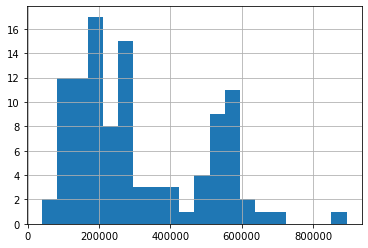

In [19]:
coops.nonzero_income_nanmean.hist(bins=20)

<AxesSubplot:>

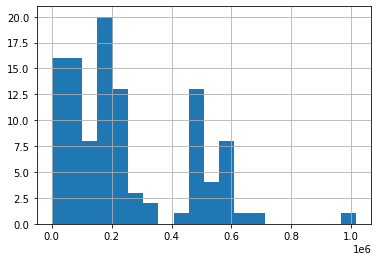

In [20]:
coops.income_nanmedian.hist(bins=20)

<AxesSubplot:>

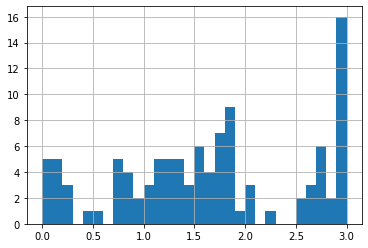

In [21]:
coops.income_binned_nanmean.hist(bins=30)

The first two plots tell essentially the same story, namely, there is a pronounced division of coops into "poor" (those with mean or median income less than 300000) and "middle class" (with incomes in the range 40000 to 700000). The third plot tells a more nuanced story:  When income is binned into four quartiles (values = 0, 1, 2, 3) and averaged within coops, then coops with higher mean binned incomes are actually more frequent, with 33 coops having a mean binned income ≥ 2 .  That is, 33 coops have an average income in the upper quartile of income. 

# Group statistics for villages #

Let's have a quick look at group statistics for villages.  Run the following code block to see the village data. The first thing to notice is the variation in village sizes.  You might want to aggregate by commune if village sizes are too small for your analysis.  Note that some villages have no id or location or name; for example, row 3 of the table. Most of these villages have only one denizen.  Their names are probably misspelled.  I'll track this down and correct it, soon. 

Note that we don't know how big a village is, just as we don't know how big a coop is.  We only know how many farmers say that they belong to a village.  So, a village might have 200 farms in reality, but village_size might be 3 if field agents visited only three farms in that village.

In [22]:
villages = pd.read_csv(filepath+"village_stats_20210209.csv")
villages.head(10)

,village_id,Object.state,Status,Accuracy,Date,commune,village_name,lat_long,has_rain_gauge,village_size,gender_nanmean,gender_nanmedian,gender_N,age_nanmean,age_nanmedian,age_N,years_farming_nanmean,years_farming_nanmedian,years_farming_N,num_wives_nanmean,num_wives_nanmedian,num_wives_N,wife_trades_nanmean,wife_trades_nanmedian,wife_trades_N,wife_food_crops_nanmean,wife_food_crops_nanmedian,wife_food_crops_N,wife_crafts_nanmean,wife_crafts_nanmedian,wife_crafts_N,num_children_nanmean,num_children_nanmedian,num_children_N,num_young_children_nanmean,num_young_children_nanmedian,num_young_children_N,num_older_children_nanmean,num_older_children_nanmedian,num_older_children_N,num_children_in_school_nanmean,num_children_in_school_nanmedian,num_children_in_school_N,children_working_nanmean,children_working_nanmedian,children_working_N,housing_material_nanmean,housing_material_nanmedian,housing_material_N,access_electricity_nanmean,access_electricity_nanmedian,access_electricity_N,access_drinking_water_nanmean,access_drinking_water_nanmedian,access_drinking_water_N,access_healthcare_nanmean,access_healthcare_nanmedian,access_healthcare_N,wants_credit_nanmean,wants_credit_nanmedian,wants_credit_N,credit_from_coop_nanmean,credit_from_coop_nanmedian,credit_from_coop_N,credit_from_third_party_nanmean,credit_from_third_party_nanmedian,credit_from_third_party_N,credit_from_bank_nanmean,credit_from_bank_nanmedian,credit_from_bank_N,has_loan_nanmean,has_loan_nanmedian,has_loan_N,loan_amount_nanmean,loan_amount_nanmedian,loan_amount_N,loan_rate_nanmean,loan_rate_nanmedian,loan_rate_N,has_bridge_loan_nanmean,has_bridge_loan_nanmedian,has_bridge_loan_N,bridge_loan_amount_nanmean,bridge_loan_amount_nanmedian,bridge_loan_amount_N,pledged_output_nanmean,pledged_output_nanmedian,pledged_output_N,wants_bridge_loan_nanmean,wants_bridge_loan_nanmedian,wants_bridge_loan_N,wants_bridge_loan_amount_nanmean,wants_bridge_loan_amount_nanmedian,wants_bridge_loan_amount_N,input_use_nanmean,input_use_nanmedian,input_use_N,input_cost_nanmean,input_cost_nanmedian,input_cost_N,inputs_useful_nanmean,inputs_useful_nanmedian,inputs_useful_N,interest_use_inputs_nanmean,interest_use_inputs_nanmedian,interest_use_inputs_N,interest_insurance_nanmean,interest_insurance_nanmedian,interest_insurance_N,use_ag_services_nanmean,use_ag_services_nanmedian,use_ag_services_N,ag_services_quality_nanmean,ag_services_quality_nanmedian,ag_services_quality_N,ag_services_frequency_nanmean,ag_services_frequency_nanmedian,ag_services_frequency_N,interest_ag_services_nanmean,interest_ag_services_nanmedian,interest_ag_services_N,last_price_nanmean,last_price_nanmedian,last_price_N,num_plots_nanmean,num_plots_nanmedian,num_plots_N,total_ha_nanmean,total_ha_nanmedian,total_ha_N,fraction_in_school_nanmean,fraction_in_school_nanmedian,fraction_in_school_N,fraction_in_school_binned_nanmean,fraction_in_school_binned_nanmedian,fraction_in_school_binned_N,num_older_children_binned_nanmean,num_older_children_binned_nanmedian,num_older_children_binned_N,num_young_children_binned_nanmean,num_young_children_binned_nanmedian,num_young_children_binned_N,income_nanmean,income_nanmedian,income_N,nonzero_income_nanmean,nonzero_income_nanmedian,nonzero_income_N,income_binned_nanmean,income_binned_nanmedian,income_binned_N,num_plots_binned_nanmean,num_plots_binned_nanmedian,num_plots_binned_N,years_farming_binned_nanmean,years_farming_binned_nanmedian,years_farming_binned_N,age_binned_nanmean,age_binned_nanmedian,age_binned_N,num_children_binned_nanmean,num_children_binned_nanmedian,num_children_binned_N,num_wives_binned_nanmean,num_wives_binned_nanmedian,num_wives_binned_N,education_level_binned_nanmean,education_level_binned_nanmedian,education_level_binned_N,wife_roles_nanmean,wife_roles_nanmedian,wife_roles_N,creditworthy_nanmean,creditworthy_nanmedian,creditworthy_N
0,423.0,Locked,Enable,3.0,2018-01-22 10:04:00,Ronkh,Diawar,-16.050963029265 | 16.458946231421,no,262.0,0.122137,0.0,262.0,45.068702,44.0,2


There are interesting results here, though I suspect that some are due to sampling too few members of a village.  To reiterate: We don't know the true village size.  So, Ross bEthio (row 4) has 20 respondents of which the mean gender is 0.95. Now, gender might be 0 (monsieur) or 1 (madame) or 2 (madamoiselle) so we don't know exactly how many of each respondent we got, but, clearly, almost all were female. The respondents said the number of wives is zero.  A village of women? Hard to tell. 

Note that recoding many categorical values as integers ranging from "bad to good" or "low to high" or, generally, negative to positive valence pays off here. We can look at a variable such as pledged_output_nanmean (with values 0 or 1) to get the proportion of a village that has pledged its output. 

<AxesSubplot:>

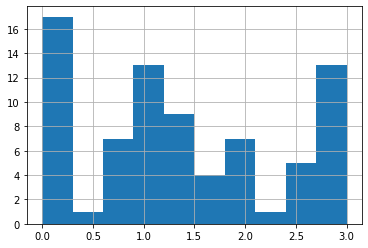

In [23]:
villages.income_binned_nanmean.hist()